In [ ]:
import pennylane as qml
import pennylane.numpy as nps
import sys
sys.path.insert(0, '..')
num_qubits = 4
num_layers = 2
graph = [(0, 1), (0, 3), (1, 2), (2, 3)]


dev = qml.device("default.qubit")
@qml.qnode(dev, diff_method="parameter-shift")
def circuit(thetas):
    j = 0
    for _ in range(0, num_layers):
        for i in range(0, num_qubits - 1):
            qml.CRY(thetas[j], wires=[i,i+1])
            j += 1
        qml.CRY(thetas[j], wires=[num_qubits - 1, 0])
        j += 1
        for i in range(0, num_qubits):
            qml.RZ(thetas[j], wires=i)
            qml.RX(thetas[j+1], wires=i)
            qml.RZ(thetas[j+2], wires=i)
            j += 3
    # during the optimization phase we are evaluating the objective using expval
    C = qml.sum(*(qml.Z(w1) @ qml.Z(w2) for w1, w2 in graph))
    return qml.expval(C)


def cost_fn(params):
    """Minimize the negative of the objective function C by postprocessing the QNnode output."""
    return -0.5 * (len(graph) - circuit(params))

def qaoa(opt, num_layers):
    thetas = nps.random.uniform(0, 2*nps.pi, 4 * num_qubits * num_layers)
    steps = 400
    costs = []
    grad_func = qml.grad(cost_fn)
    for i in range(steps):
        thetas, cost = opt.step_and_cost(cost_fn, thetas, grad_fn = grad_func)
        costs.append(cost)
    return costs

In [ ]:
from qoop.core import optimizer_pennylane
import numpy as np
optimizer_funcs = [qml.AdamOptimizer, 
             optimizer_pennylane.AdamWOptimizer,
             optimizer_pennylane.AMSGradOptimizer,
             optimizer_pennylane.NadamOptimizer,
             optimizer_pennylane.RAdamOptimizer,
             optimizer_pennylane.QHAdamOptimizer,
             optimizer_pennylane.AdamaxOptimizer]

costss = []
num_layers = 2
step_sizes = np.linspace(0.01, 0.1, 19)
for optimizer_func in optimizer_funcs:
    for stepsize in step_sizes:
        print(optimizer_func.__name__)
        opt = optimizer_func(stepsize = stepsize)
        costs = qaoa(opt, num_layers)
        np.savetxt(f"../data/loss/lossqaoa_{num_qubits}qubit_{num_layers}layer_{optimizer_func.__name__}_stepsize{stepsize}.txt", costs)
        costss.append(costs)


AdamOptimizer
AdamWOptimizer
AMSGradOptimizer
NadamOptimizer
RAdamOptimizer
QHAdamOptimizer
AdamaxOptimizer


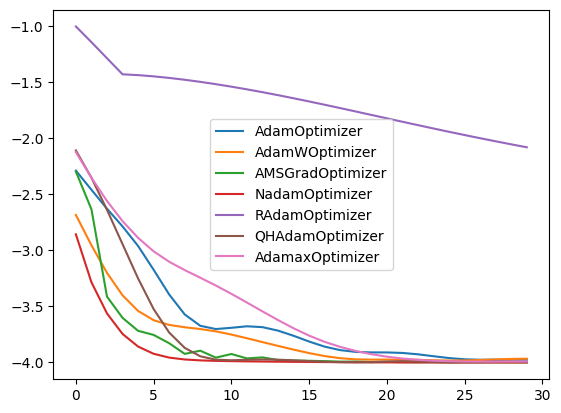

In [31]:
import matplotlib.pyplot as plt
for j, optimizer_func in enumerate(optimizer_funcs):
    costs = np.loadtxt(f"../data/loss/lossqaoa_{num_qubits}qubit_{num_layers}layer_{optimizer_func.__name__}.txt")
    plt.plot(costs[:50], label = optimizer_func.__name__)
plt.legend()